<a href="https://colab.research.google.com/github/LionelAgo/Vortex_AE/blob/master/Vortex_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages + Drive

1 - Install necessary package

2 - Import packages

3- mount drive

In [0]:
# - 2
#from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
#tf.enable_eager_execution()
import numpy as np
import matplotlib.pyplot as plt
import h5py



# check tensorflow version, we want the one that support eager mode
tf.__version__

'1.14.0'

In [0]:
# - 3
from google.colab import drive
drive.mount('/content/drive')
#!ls "/content/drive/My Drive/Colab Notebooks"
import os
dir="/content/drive/My Drive/Colab Notebooks/Vortex/"
os.chdir(dir)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Load Jet data + Preprocessing

## Load data 
Data avaible: 
https://app.box.com/s/24wakswab2di53eu2l9wx6e65nf4nn2x

In [0]:
hf = h5py.File('U.h5', 'r')
U = hf.get('U')
U = np.array(U)
hf.close()
print(f'data downloaded')


data downloaded


##  Prepare Data for Autoencoder 


1.  **Feature scaling**

       - MinMaxScaler -> speed up training process (last layer: sigmoid)
2.  **build matrice with temporal shift for embbeded the dynamic** 
      - CNN with conv3d      
2. **Split the Data for training and validation**
      - multiple of 128 ( memory optimisation for TPU)
      - Temporel shift can be introduced between the input and ouput for reinforce the dynamic in Latent space


       
       





In [0]:
# - 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0.01, 0.99))

def scaleC(tmp='U'):
  nt,nx,nz=np.shape(tmp)
  tmp=np.reshape(tmp,(nt,nx*nz))
  tmp=scaler.fit_transform(tmp.T)
  tmp=tmp.T
  tmp=np.reshape(tmp,(nt,nx,nz,1))
  #tmp=np.expand_dims(tmp,axis=4)
  tmp=tmp[:,2:-2,2:,:]
  return tmp

U=scaleC(U)
#V=scaleC(V)
#Om=scaleC(Om)
#S=scaleC(S)
print(f'Database size_{np.shape(U)}')

Database size_(501, 256, 88, 1)


In [0]:

# - 2
def data4AE3d(v,dt=8):

  nt,nx,nz,nc=np.shape(v) 
  for i in np.arange(0,dt):
    t=v[i:int(nt-dt+i),:,:,:]
    t=np.expand_dims(t,1)
    if i==0:
      tmp=t
    else:
      tmp=np.concatenate((tmp,t),axis=1)
  return tmp  

dt=12
Ut=data4AE3d(U,dt)


In [0]:
# - 3
tshift=0
Utrain_1 = Ut[0:int(1*128),:,:,:,:].astype(np.float32)
Utrain_2 = Ut[tshift:int(tshift+1*128),:,:,:,:].astype(np.float32)

#Build Autoencoder (CCN)
   -  latent dimension define by : nl

In [0]:
#model=CAE_3L()
nl=3
filters=[8*2, 16*2, 32*2 , nl]

def CAE_3L_comp(nl=int(nl), filters=filters):
  
  nt,dt,nx,nz,nc=np.shape(Ut)
 
  #filters=[8*2, 16*2, 32*2, nl]
  
  rate=0.0
  
  nm=8
  nm0=4
  
  #act=lambda x: tf.nn.leaky_relu(x, alpha=0.2)
  act=lambda x: tf.nn.elu(x)

  input_shape=(dt,nx,nz, nc)
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.GaussianNoise(rate, input_shape=input_shape, name='noise'))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.Conv3D(filters[0], (5,5,5), strides=1,dilation_rate=1, activation=act, padding='same', name='conv1')) #5
  model.add(tf.keras.layers.MaxPooling3D( pool_size=(2,2,2), strides=(2,2,2), padding='same')) #2 2

  model.add(tf.keras.layers.Conv3D(filters[1], (3,3,3), strides=1, activation=act, padding='same', name='conv2'))
  model.add(tf.keras.layers.MaxPooling3D( pool_size=(2,2,2), strides=(2,2,2), padding='same'))

  model.add(tf.keras.layers.Conv3D(filters[2], (3,3,3), activation=act, padding='same', name='conv3'))
  model.add(tf.keras.layers.MaxPooling3D( pool_size=(1,2,2), strides=(1,2,2), padding='same'))


  model.add(tf.keras.layers.Flatten())
  #model.add(tf.keras.layers.Dense(units=filters[3],activity_regularizer=tf.keras.regularizers.l1_l2(l1=10e-6,l2=10e-6), name='bottleneck'))
  model.add(tf.keras.layers.Dense(units=filters[3],activation=act, name='bottleneck'))

  model.add(tf.keras.layers.Dense(units=filters[2]*int(input_shape[0]/nm0)*int(input_shape[1]/nm)*int(input_shape[2]/nm)))
  model.add(tf.keras.layers.Reshape((int(input_shape[0]/nm0), int(input_shape[1]/nm), int(input_shape[2]/nm) , filters[2])))

  model.add(tf.keras.layers.UpSampling3D((1,2,2),data_format=None ))
  model.add(tf.keras.layers.Conv3DTranspose(filters[2], (3,3,3), strides=1,dilation_rate=1, activation=act, padding='same', name='dconv3'))
  model.add(tf.keras.layers.UpSampling3D((2,2,2),data_format=None ))
  model.add(tf.keras.layers.Conv3DTranspose(filters[1], (3,3,3), strides=1,dilation_rate=1, activation=act, padding='same', name='dconv2'))
  model.add(tf.keras.layers.UpSampling3D((2, 2,2),data_format=None ))
  model.add(tf.keras.layers.Conv3DTranspose(filters[0], (5,5,5), strides=1,dilation_rate=1, activation=act, padding='same', name='dconv1'))
  model.add(tf.keras.layers.Conv3DTranspose(1, (1,1,1), activation='sigmoid', padding='same', name='last'))
  

  
  return model

model=CAE_3L_comp()
model.summary()


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noise (GaussianNoise)        (None, 12, 256, 88, 1)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 256, 88, 1)    4         
_________________________________________________________________
conv1 (Conv3D)               (None, 12, 256, 88, 16)   2016      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 6, 128, 44, 16)    0         
_________________________________________________________________
conv2 (Conv3D)               (None, 6, 128, 44, 32)    13856     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 3, 64, 22, 32)     0         
____

## setup connection to TPU

In [0]:

resolver = tf.contrib.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.contrib.distribute.initialize_tpu_system(resolver)
strategy = tf.contrib.distribute.TPUStrategy(resolver)



INFO:tensorflow:Initializing the TPU system.
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Querying Tensorflow master (grpc://10.41.176.66:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 11206640103107541255)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 3704408818169105348)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 1966180494079374330)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 8100781487451093761)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 1717

## Define  loss functions

1.   **quantile_loss**  
     - q=0.5 similar to mean square error (similar to POD for linear activation function)
     - q<0.5 more accuracy for negative-fluctuation events
     - q>0.5 more accuracy for positive-fluctuation events
2.   **resemblance**

      - I created this function in order to measure the likeness between the original and predicted image.
      
                ***Rs*** factor is not weighted by energy and Rs<=1

     
    

In [0]:

def quantile_loss(y_true, y_pred):
    q=0.5 # similar to mae
    e = y_true - y_pred
    return tf.reduce_mean(tf.maximum(q*e, (q-1)*e), axis=-1)


def resemblance(y_true, y_pred):
    q=8
    epsi=0.0001
    A=y_true+epsi
    B=y_pred+epsi
    alp=2*abs(A*B)/(A**2+B**2)
    alp=abs(1-alp**(q))
    return tf.reduce_mean(alp)
  
  

# Train and evaluate model


1.   Train
2.   Evaluate
3.  Save



In [0]:
with strategy.scope():
  model = CAE_3L_comp()
  model.compile(optimizer=tf.keras.optimizers.Adamax(),loss=resemblance,metrics=['mape'])

In [0]:



history=model.fit(
          Utrain_1, Utrain_2,
          epochs=128, #64
          steps_per_epoch=8, 
          )

namesave=f'Vs_{nl}dim_dt{dt}_3L_filter_{filters[0]}_{filters[1]}_{filters[2]}'               
model.save_weights(namesave+'.h5', overwrite=True)
print(f'Saved model to disk - {namesave}')
prout

**Plot  training history**

In [0]:
print(history.history.keys())


In [0]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['mean_absolute_percentage_error'])
#plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.title('mean_absolute_percentage_error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xlim(left=400)
#plt.ylim(top=1.5)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Load model

In [0]:

namesave=f'Vs_{nl}dim_dt{dt}_3L_filter_{filters[0]}_{filters[1]}_{filters[2]}'               
print("model Loaded from disk")

with strategy.scope():
  model = CAE_3L_comp()
  model.compile(
      optimizer=tf.keras.optimizers.Adamax(),
      loss=resemblance,
      metrics=['mape'])
  model.load_weights(namesave+'.h5')


# Evaluation model 

In [0]:

model.evaluate(Ut[-128:,:,:,:,:].astype(np.float32), Ut[-128:,:,:,:,:].astype(np.float32))
#np.shape(X1_val)

4/4 [==============================] - 14s 3s/step


[0.002008323557674885, 0.34904698]

# Auto - encoder

## Encoder - Decoder

In [0]:

# Decoder  for CAE_3L_comp()

def define_dec():
  encoder = tf.keras.Model(model.input, model.get_layer('bottleneck').output)

  input_img = tf.keras.Input(shape=(nl,))

  K=10
  dec_1 = model.layers[int(K)]
  dec_2 = model.layers[int(K+1)]
  dec_3 = model.layers[int(K+2)]
  dec_4 = model.layers[int(K+3)]
  dec_5 = model.layers[int(K+4)]
  dec_6 = model.layers[int(K+5)]
  dec_7 = model.layers[int(K+6)]
  dec_8 = model.layers[int(K+7)]
  dec_9 = model.layers[int(K+8)]
  decoder = tf.keras.Model(input_img, ((dec_9(dec_8(dec_7(dec_6(dec_5(dec_4(dec_3(dec_2(dec_1(input_img))))))))))))
  
  return encoder, decoder    

encoder, decoder = define_dec() 

In [0]:
#X1=Ut[:,:,:,:,:].astype(np.float32)
#Renc = model.predict(X1)

## Encoding - Decoding

**dimensionality reduction:**
- Encoder --> Latent space (Zenc)
---

In [0]:
# if k=1 compile, else  load data
def Zenc_def(k=1):
  if k==1:
    X1=Ut[:,:,:,:,:].astype(np.float32)
    Zenc = encoder.predict(X1)
    print(f'size_of_latent_dim_{np.shape(Zenc)}')
    hf = h5py.File('Zenc_F64.h5', 'w')
    hf.create_dataset('Zenc', data=Zenc, compression='gzip')
    hf.close()   
  else:
    hf = h5py.File('Zenc_F64.h5', 'r')
    n1 = hf.get('Zenc')
    Zenc = np.array(n1)
    hf.close()
  return Zenc  

Zenc=Zenc_def()  

**Reconstruct:**
 - Latent space --> Decoder (Renc)
---


In [0]:
# if k=1 compile, else  load data
def Renc_def(k=1):
  if 1==2:
    import time
    start = time.process_time()
    Renc=decoder.predict(Zenc[:,:])
    print(f'size_of_reconstructed_field_{np.shape(Renc)}')
    print(time.process_time() - start)
    Renc=np.squeeze(Renc[:,0,:,:,0])
    hf = h5py.File('Renc_F64.h5', 'w')
    hf.create_dataset('Renc', data=Renc, compression='gzip')
    hf.close() 
  else:
    hf = h5py.File('Renc_F64.h5', 'r')
    n1 = hf.get('Renc')
    Renc = np.array(n1)
    hf.close()
  return Renc

Renc=Renc_def()      

# Visualisation of Reconstructed field   

## Original vs Reconstructed by AE

In [0]:
def np_resemblance(y_true, y_pred):
    q=128
    epsi=0.0001
    A=y_true+epsi
    B=y_pred+epsi
    alp=2*abs(A*B)/(A**2+B**2)
    alp=abs(1-alp**(q))
    return alp

snapshot 63


Text(0.5, 1.0, 'Resemblance')

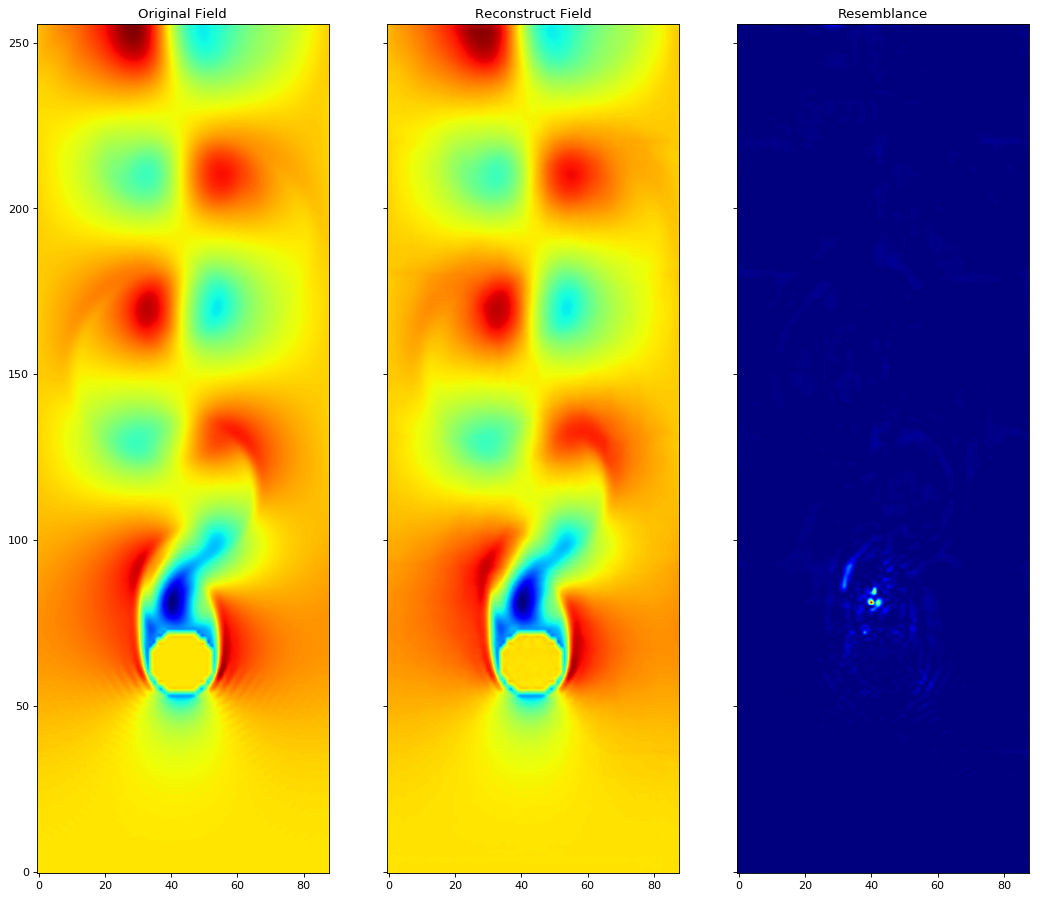

In [0]:
delta_t=0
dti=0
nt=500
ni=np.random.randint(0,nt)
#ni=99
print(f'snapshot {ni}')
n=0


f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(16, 16), dpi=80, facecolor='w', edgecolor='k')

tmp=np.squeeze(Ut[ni+delta_t,dti,:,:,n])
z_min, z_max = tmp.min(),tmp.max()
ax1.imshow(tmp, cmap='jet', vmin=z_min, vmax=z_max, interpolation='spline16', origin='lower')
ax1.set_title('Original Field')
               
tmpi=np.squeeze(Renc[ni,:,:])                
ax2.imshow(tmpi, cmap='jet', vmin=z_min, vmax=z_max, interpolation='spline16', origin='lower')
ax2.set_title('Reconstruct Field AE')

alp=np_resemblance(tmp, tmpi)
z_min, z_max = alp.min(),alp.max()
ax3.imshow(alp, cmap='jet', vmin=0, vmax=1, interpolation='spline16', origin='lower')
ax3.set_title('Resemblance')
#print(f'{z_min}_{z_max}_mean_{np.mean(alp)}')



## Error estimation

$Xori$: original field

$Xrec$: reconstructed field

\begin{align}
\phi^n & = 100 \times \int\int\frac{\sqrt{(Xrec^n - Xori^n)^2}}{Xori^n} dx dz
\end{align}

(0, 480)

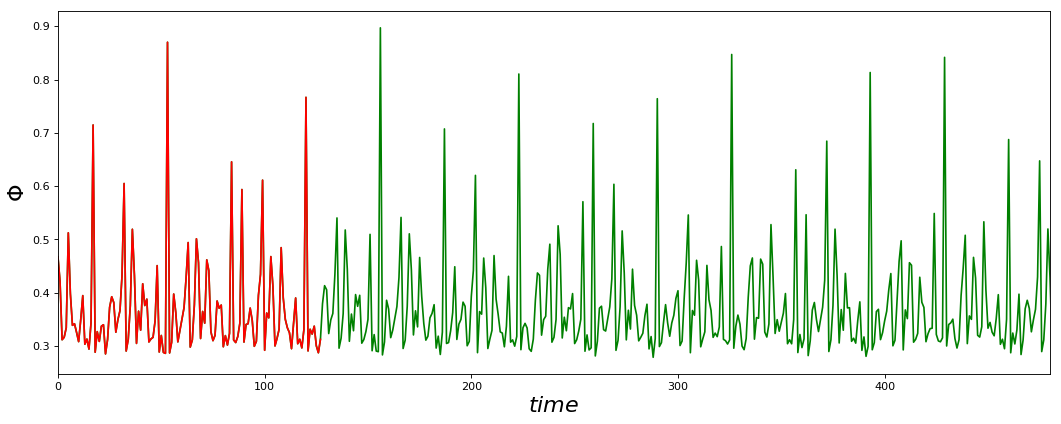

In [0]:
ix=0
n=0
VRenc=[]
VPod=[]
#dp=Ut[:,0,:,:,:]
xl=range(0,88)

for ni in range(Ut.shape[0]):
  ix +=1
  tmp=np.squeeze(Ut[ni+delta_t,0,:,:,n])  
  tmp2=np.squeeze(Renc[ni,:,:]) 
  val=0
  nn=1
  val=100*np.mean(abs(tmp2[:,xl]**nn - tmp[:,xl]**nn)/abs(tmp[:,xl]**nn))
  #np.shape(val)
  if ix==1:
    VRenc=val
  else:
    VRenc=np.vstack((VRenc,val))

    

_,ax = plt.subplots(1, 1, sharey=True,figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')

ax.plot(VRenc,'g-')
ax.plot(VRenc[:1*128],'r-')
ax.set_xlim(0,4*128)
ax.set_ylabel('$\Phi^2$', fontsize=20)
ax.set_xlabel('$time$', fontsize=20)
#ax.set_ylim(0,0.2)
ax.set_xlim(0,480)



